In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import os
from os import path
from scipy import stats, signal, ndimage
from tqdm.notebook import tqdm
import math
import time
import pickle
import glob
import random

%matplotlib inline

import seaborn as sns
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

from analysis_helpers import load_data, savefig, load_data_by_session_id, heatmap_log_proba_plot

from eye_tracking.eye_tracking import get_saccade_magnitude_direction, get_stim_at_frame
from eye_plotting import STIM_ABBREV, STIM_COLORS, STIM_ORDERING
from experiment.cre_line import match_cre_line, CRE_COLORS, CRE_ORDERING

In [2]:
"""
Filter used to smooth the running speed trace.
"""
def smooth_run_speed(data, method="gaussian"):
    if method == "savgol":
        return signal.savgol_filter(data, 51, 3)
    elif method == "gaussian":
        return ndimage.filters.gaussian_filter1d(data, 10)
    else:
        return None

In [3]:
df_sacc_rows = []
df_exp_rows = []
df_sacc_bin_rows = []
df_stim_rows = []

running_threshold = 0.5 # cm/s
window_width = 30 * 60 # frames (= 60 sec)

for data in load_data(tqdm_desc="Saccade statistics"):
    eye_tracking = data["eye_tracking"]
    start, end = data["start_end"]
    saccades = data["saccades"]
    running_speed_smoothed = smooth_run_speed(data["running_speed"])
    stim_epoch = data["stim_epoch"]
    cre_line = match_cre_line(data)
    specimen_name = data["metadata"]["specimen_name"]

    df_exp_rows.append({
        "cre_line": cre_line,
        "cre_abbrev": str(cre_line),
        "mean_running_speed": np.nanmean(running_speed_smoothed[start:end]),
        "fraction_running": np.nanmean(running_speed_smoothed[start:end] > running_threshold),
        "mean_pupil_area": float(np.nanmean(eye_tracking["pupil_area"].loc[start:end-1])),
        "n_saccades": len(saccades),
        "mean_sacc_per_sec": len(saccades) / ((end-start) / 30),
        "sex": data["metadata"]["sex"],
        "age": data["metadata"]["age_days"],
        "duration_seconds": (end-start)/30,
        "specimen_name": specimen_name,
    })

    for ss, se in saccades:
        stim = get_stim_at_frame(stim_epoch, ss)
        peak_speed = eye_tracking["speed"].loc[ss:se-1].max()
        mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
        run = running_speed_smoothed[ss-30:ss+30].mean()
        mean_pupil_area = float(np.nanmean(eye_tracking["pupil_area"].loc[ss-15:ss+15]))
        
        df_sacc_rows.append({
            "cre_line": cre_line,
            "cre_abbrev": str(cre_line),
            "specimen_name": specimen_name,
            "stim": get_stim_at_frame(stim_epoch, ss),
            "duration": (se-ss)/30,
            "direction": dir,
            "magnitude": mag,
            "peak_speed": peak_speed,
            "mean_running_speed": run,
            "mean_pupil_area": mean_pupil_area,
            "dx": eye_tracking["x_pos_deg"].loc[se] - eye_tracking["x_pos_deg"][ss],
        })
    
    for start_frame in range(start, end-window_width+1, window_width): # Ensure all bins are window_width
        end_frame = start_frame + window_width
        run_trace = running_speed_smoothed[start_frame:end_frame]
        n_saccades = 0
        n_saccades_nasal = 0
        n_saccades_temporal = 0
        for ss, se in saccades:
            if start_frame <= ss < end_frame:
                n_saccades += 1
                mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
                if dir == "L": n_saccades_nasal += 1
                elif dir == "R": n_saccades_temporal += 1
        pupil_trace = eye_tracking["pupil_area"].loc[start_frame:end_frame-1]

        df_sacc_bin_rows.append({
            "cre_line": cre_line,
            "cre_abbrev": str(cre_line),
            "stim": get_stim_at_frame(stim_epoch, (start_frame+end_frame)//2),
            "mean_running_speed": float(np.nanmean(run_trace)),
            "fraction_running": float(np.nanmean(run_trace > running_threshold)),
            "n_saccades": n_saccades,
            "mean_sacc_per_sec": n_saccades / (window_width/30),
            "nasal_sacc_freq": n_saccades_nasal/window_width*30,
            "temporal_sacc_freq": n_saccades_temporal/window_width*30,
            "mean_pupil_area": float(np.nanmean(pupil_trace)),
        })
    
    for stim_name in stim_epoch.stimulus.unique():
        stim_epoch_sub = stim_epoch[stim_epoch.stimulus == stim_name]
        n_saccades = 0
        n_saccades_nasal = 0
        n_saccades_temporal = 0
        n_frames = 0

        for j in range(len(stim_epoch_sub)):
            stim_start = stim_epoch_sub.start.iloc[j]
            stim_end = stim_epoch_sub.end.iloc[j]
            n_frames += stim_end - stim_start

            # Find saccades during this window
            for ss, se in saccades:
                if stim_start <= ss and se < stim_end:
                    n_saccades += 1
                    mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
                    if dir == "L": n_saccades_nasal += 1
                    elif dir == "R": n_saccades_temporal += 1
                elif stim_end < ss:
                    break # Since saccades are ordered by frame
        
        df_stim_rows.append({
            "cre_line": cre_line,
            "cre_abbrev": str(cre_line),
            "specimen_name": specimen_name,
            "stim": stim_name,
            "n_saccades": n_saccades,
            "n_frames": n_frames,
            "mean_sacc_per_sec": n_saccades / (n_frames/30),
            "nasal_sacc_freq": n_saccades_nasal/n_frames*30,
            "temporal_sacc_freq": n_saccades_temporal/n_frames*30,
        })


df_saccades = pd.DataFrame(df_sacc_rows)
df_experiments = pd.DataFrame(df_exp_rows)
df_binned = pd.DataFrame(df_sacc_bin_rows)
df_stim = pd.DataFrame(df_stim_rows)
df_stim["stim_abbrev"] = df_stim.apply(lambda row: STIM_ABBREV[row["stim"]], axis=1)
df_saccades.head()

Saccade statistics:   0%|          | 0/818 [00:00<?, ?it/s]

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


,cre_line,cre_abbrev,specimen_name,stim,duration,direction,magnitude,peak_speed,mean_running_speed,mean_pupil_area,dx
0,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_4deg,0.100000,L,0.128292,70.011660,0.002462,0.003900,-0.126131
1,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,4.511047,64.262569,-0.001165,0.004208,4.458092
2,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.133333,R,3.013002,44.197989,-0.266592,0.005606,2.957298
3,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,L,9.012816,133.702206,-0.350692,0.009126,-8.981052
4,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,6.400596,88.736315,0.971764,0.007928,6.381285


In [4]:
mask_L_saccades = df_saccades["direction"].values == "L"
mask_R_saccades = df_saccades["direction"].values == "R"

print(f"There are {len(df_saccades):,} total saccades across {len(df_experiments)} experiments.")
print(f"  Number of left (nasal) saccades: {mask_L_saccades.sum():,}")
print(f"  Number of right (temporal) saccades: {mask_R_saccades.sum():,}")
print(f"  Number of up/down saccades: {(len(mask_L_saccades) - mask_L_saccades.sum() - mask_R_saccades.sum()):,}")

There are 202,156 total saccades across 818 experiments.
  Number of left (nasal) saccades: 104,121
  Number of right (temporal) saccades: 91,037
  Number of up/down saccades: 6,998


<AxesSubplot:xlabel='duration_seconds', ylabel='Count'>

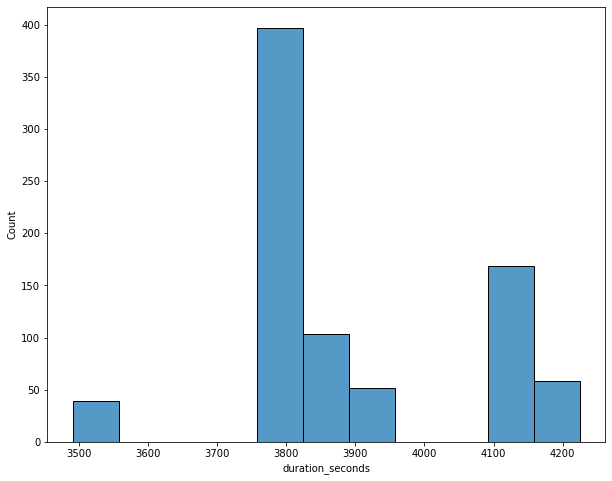

In [5]:
fig = plt.figure(facecolor="white", figsize=(10, 8))
sns.histplot(data=df_experiments, x="duration_seconds")

In [6]:
df_binned.head()

,cre_line,cre_abbrev,stim,mean_running_speed,fraction_running,n_saccades,mean_sacc_per_sec,nasal_sacc_freq,temporal_sacc_freq,mean_pupil_area
0,Sst; Ai148,Sst; Ai148,locally_sparse_noise_4deg,-0.000387,0.0,0,0.0,0.0,0.0,0.003664
1,Sst; Ai148,Sst; Ai148,locally_sparse_noise_4deg,-0.001222,0.0,0,0.0,0.0,0.0,0.003469
2,Sst; Ai148,Sst; Ai148,locally_sparse_noise_4deg,-0.001410,0.0,0,0.0,0.0,0.0,0.003506
3,Sst; Ai148,Sst; Ai148,locally_sparse_noise_4deg,0.002366,0.0,0,0.0,0.0,0.0,0.003758
4,Sst; Ai148,Sst; Ai148,locally_sparse_noise_4deg,0.000181,0.0,0,0.0,0.0,0.0,0.003956


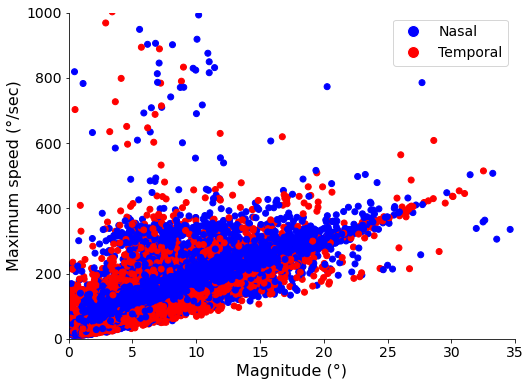

In [7]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
color = np.where(mask_L_saccades, "blue", np.where(mask_R_saccades, "red", ""))
color = color[color != ""]
ax.scatter(df_saccades["magnitude"].values[mask_L_saccades | mask_R_saccades], df_saccades["peak_speed"].values[mask_L_saccades | mask_R_saccades], color=color)
# ax.scatter(df_saccades["magnitude"].values[mask_L_saccades], df_saccades["peak_speed"].values[mask_L_saccades], color="blue", label="Nasal")
# ax.scatter(df_saccades["magnitude"].values[mask_R_saccades], df_saccades["peak_speed"].values[mask_R_saccades], color="red", label="Temporal")

legend_handles = [
    Line2D([0], [0], color="white", marker="o", markersize=12, label="Nasal", markerfacecolor="blue"),
    Line2D([0], [0], color="white", marker="o", markersize=12, label="Temporal", markerfacecolor="red"),
]
ax.legend(handles=legend_handles, fontsize=14, frameon=True)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
# ax.set_title("Maximum speed of saccades by magnitude", fontsize=18)
ax.set_xlabel("Magnitude (°)", fontsize=16)
ax.set_ylabel("Maximum speed (°/sec)", fontsize=16)
ax.set_xlim(0, 35)
ax.set_ylim(0, 1000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
savefig(fig, "saccade_max_speed_by_mag.png")

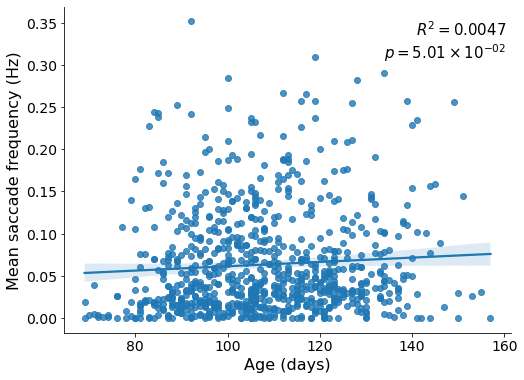

In [8]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
sns.regplot(data=df_experiments, x="age", y="mean_sacc_per_sec")
# ax.scatter(df_saccades["magnitude"].values[mask_L_saccades], df_saccades["peak_speed"].values[mask_L_saccades], color="blue", label="Nasal")
# ax.scatter(df_saccades["magnitude"].values[mask_R_saccades], df_saccades["peak_speed"].values[mask_R_saccades], color="red", label="Temporal")

# legend_handles = [
#     Line2D([0], [0], color="white", marker="o", markersize=12, label="Male", markerfacecolor="purple"),
#     Line2D([0], [0], color="white", marker="o", markersize=12, label="Female", markerfacecolor="blue"),
# ]
# ax.legend(handles=legend_handles, fontsize=14, frameon=True)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
# ax.set_title("Maximum speed of saccades by magnitude", fontsize=18)
ax.set_xlabel("Age (days)", fontsize=16)
ax.set_ylabel("Mean saccade frequency (Hz)", fontsize=16)
# ax.set_xlim(0, 35)
# ax.set_ylim(0, 1000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

r, p = stats.pearsonr(df_experiments["age"], df_experiments["mean_sacc_per_sec"])
pstr = f"{p:.2e}".split("e")
r2_text = fr"$R^2 = {r**2:.4f}$"
p_text = fr"$p = {pstr[0]} \times 10^{'{' + pstr[1] + '}'}$"
ax.text(0.99, 0.96, f"{r2_text}\n{p_text}", ha="right", transform=ax.transAxes, fontsize=15, va="top")

savefig(fig, "saccade_freq_vs_age.png")

In [9]:
df_experiments.groupby(["specimen_name", "sex"], as_index=False)["mean_sacc_per_sec"].mean()

,specimen_name,sex,mean_sacc_per_sec
0,Cux2-CreERT2;Camk2a-tTA;Ai93-222420,female,0.007060
1,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,male,0.037697
2,Cux2-CreERT2;Camk2a-tTA;Ai93-225037,male,0.001326
3,Cux2-CreERT2;Camk2a-tTA;Ai93-225039,male,0.000857
4,Cux2-CreERT2;Camk2a-tTA;Ai93-228378,female,0.000524
...,...,...,...
200,Vip-IRES-Cre;Ai148-354087,female,0.109678
201,Vip-IRES-Cre;Ai148-360902,female,0.144582
202,Vip-IRES-Cre;Ai148-360906,female,0.147185
203,Vip-IRES-Cre;Ai148-379345,male,0.115277


n male = 118, n female = 87
RanksumsResult(statistic=-0.5026189264065937, pvalue=0.6152322200373843)
MALE: 0.061 ± 0.055
FEMALE: 0.065 ± 0.057


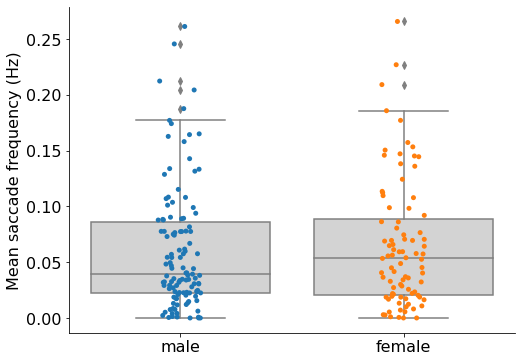

In [10]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

df = df_experiments.groupby(["specimen_name", "sex"], as_index=False)["mean_sacc_per_sec"].mean()
# female_saccades = df_experiments["mean_sacc_per_sec"].values[df_experiments["sex"] == "female"]
male_saccades = df["mean_sacc_per_sec"].values[df["sex"] == "male"]
female_saccades = df["mean_sacc_per_sec"].values[df["sex"] == "female"]
male_sem = male_saccades.std() / len(male_saccades)
female_sem = female_saccades.std() / len(female_saccades)
sns.stripplot(data=df, x="sex", y="mean_sacc_per_sec", ax=ax, order=["male", "female"]) # yerr=[male_sem, female_sem]
sns.boxplot(data=df, x="sex", y="mean_sacc_per_sec", ax=ax, color="lightgray", order=["male", "female"]) # yerr=[male_sem, female_sem]
# sns.barplot(data=df_experiments, x="sex", y="n_saccades", ci=None, ax=ax, order=["male", "female"]) # yerr=[male_sem, female_sem]
# ax.bar_label(ax.containers[0], labels=[f"${x.mean():.1} \pm {x.std():.1f}$\n$n = {len(x)}$" for x in (male_saccades, female_saccades)], label_type="center", fmt="", fontsize=16, backgroundcolor="w")

# ax.scatter(df_saccades["magnitude"].values[mask_L_saccades], df_saccades["peak_speed"].values[mask_L_saccades], color="blue", label="Nasal")
# ax.scatter(df_saccades["magnitude"].values[mask_R_saccades], df_saccades["peak_speed"].values[mask_R_saccades], color="red", label="Temporal")

# legend_handles = [
#     Line2D([0], [0], color="white", marker="o", markersize=12, label="Male", markerfacecolor="purple"),
#     Line2D([0], [0], color="white", marker="o", markersize=12, label="Female", markerfacecolor="blue"),
# ]
# ax.legend(handles=legend_handles, fontsize=14, frameon=True)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
# ax.set_title("Maximum speed of saccades by magnitude", fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("Mean saccade frequency (Hz)", fontsize=16)
# ax.set_xlim(0, 35)
# ax.set_ylim(0, 1000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
print(f"n male = {len(male_saccades)}, n female = {len(female_saccades)}")
print(stats.ranksums(male_saccades, female_saccades))
savefig(fig, "saccade_freq_vs_sex.png")
print(f"MALE: {male_saccades.mean():.3f} ± {male_saccades.std():.3f}")
print(f"FEMALE: {female_saccades.mean():.3f} ± {female_saccades.std():.3f}")

[mean_sacc_per_sec] Mean = 0.3772
[mean_sacc_per_sec] Median = 0.3078
[fraction_running] Mean = 0.4887
[fraction_running] Median = 0.4493


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':


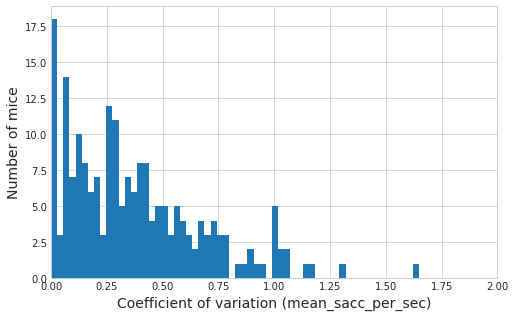

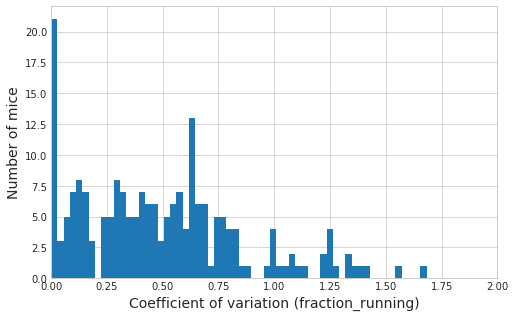

In [11]:
"""
Compute the coefficient of variation of a set of numbers.
"""
def coef_var(x):
    mean, std = np.mean(x), np.std(x)
    return std/mean if mean != 0 else np.nan

with plt.style.context("seaborn-whitegrid"):
    for metric in ["mean_sacc_per_sec", "fraction_running"]:
        fig, ax = plt.subplots(figsize=(8, 5))
        values = df_experiments.groupby("specimen_name")[metric].agg(coef_var).values
        ax.hist(values[np.isfinite(values) & (values >= 0)], bins=60)
        ax.set_xlabel(f"Coefficient of variation ({metric})", fontsize=14)
        ax.set_ylabel("Number of mice", fontsize=14)
        # ax.set_xlim(0, ax.get_xlim()[1])
        ax.set_xlim(0, 2)
        print(f"[{metric}] Mean = {np.nanmean(values):.4f}")
        print(f"[{metric}] Median = {np.nanmedian(values):.4f}")

In [12]:
df = []

# Investigate average eye position
for data in load_data(tqdm_desc="Saccade statistics"):
    eye_tracking = data["eye_tracking"]
    start, end = data["start_end"]
    saccades = data["saccades"]
    n_N, n_T = 0, 0

    for ss, se in saccades:
        mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
        if dir == "L": n_N += 1
        elif dir == "R": n_T += 1
    
    if n_N < 15 or n_T < 15:
        continue
    
    avg_x = eye_tracking["x_pos_deg"].loc[start:end-1].mean()
    avg_y = eye_tracking["y_pos_deg"].loc[start:end-1].mean()

    for ss, se in saccades:
        x0, x1 = eye_tracking["x_pos_deg"].loc[ss], eye_tracking["x_pos_deg"].loc[se]
        y0, y1 = eye_tracking["y_pos_deg"].loc[ss], eye_tracking["y_pos_deg"].loc[se]
        mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)

        if dir == "L" or dir == "R":
            df.append({
                "dir": dir,
                "x0": x0 - avg_x,
                "x1": x1 - avg_x,
                "y0": y0 - avg_y,
                "y1": y1 - avg_y,
            })

df = pd.DataFrame(df)

Saccade statistics:   0%|          | 0/818 [00:00<?, ?it/s]

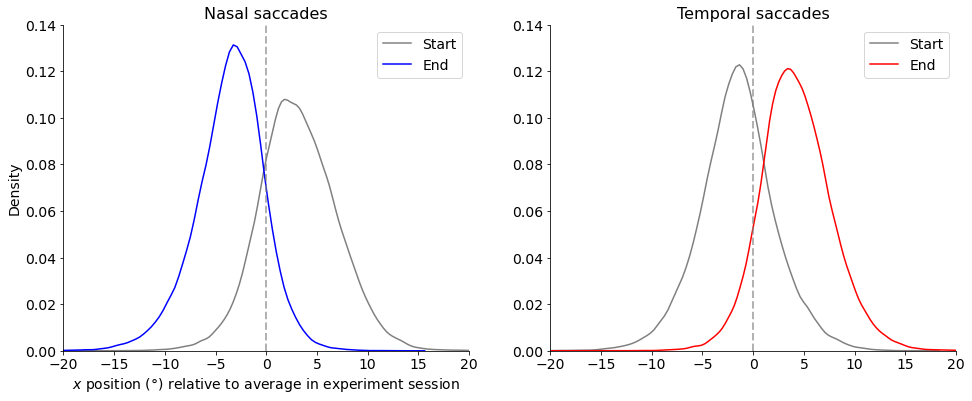

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6), facecolor="white")
sns.kdeplot(data=df[df["dir"] == "L"], x="x0", ax=axs[0], color="gray", label="Start")
sns.kdeplot(data=df[df["dir"] == "L"], x="x1", ax=axs[0], color="blue", label="End")
sns.kdeplot(data=df[df["dir"] == "R"], x="x0", ax=axs[1], color="gray", label="Start")
sns.kdeplot(data=df[df["dir"] == "R"], x="x1", ax=axs[1], color="red", label="End")

for i in range(len(axs)):
    ax = axs[i]
    ax.axvline(0, color="gray", linestyle="dashed", alpha=0.6, linewidth=2)
    ax.legend(fontsize=14, loc="upper right")
    if i == 0:
        ax.set_xlabel("$x$ position (°) relative to average in experiment session", fontsize=14)
        ax.set_ylabel("Density", fontsize=14)
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
    ax.set_xlim(-20, 20)
    ax.set_ylim(0, 0.14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)

axs[0].set_title("Nasal saccades", fontsize=16)
axs[1].set_title("Temporal saccades", fontsize=16)
savefig(fig, "ss_se_relative_to_avg.png")

In [14]:
mask_N = df["dir"] == "L"
mask_T = df["dir"] == "R"
print(f"Nasal: ({df['x0'][mask_N].mean():.2f} ± {df['x0'][mask_N].std():.2f}) --> ({df['x1'][mask_N].mean():.2f} ± {df['x1'][mask_N].std():.2f})")
print(f"Temporal: ({df['x0'][mask_T].mean():.2f} ± {df['x0'][mask_T].std():.2f}) --> ({df['x1'][mask_T].mean():.2f} ± {df['x1'][mask_T].std():.2f})")

Nasal: (3.15 ± 3.86) --> (-3.58 ± 3.43)
Temporal: (-1.56 ± 3.79) --> (4.25 ± 3.51)


In [15]:
frac_N = []
frac_T = []
mag_ratio = [] # avg T / avg N

for data in load_data(tqdm_desc="Loading fraction nasal/temporal"):
    n_total = len(data["saccades"])
    n_N, n_T = 0, 0
    mag_N, mag_T = 0, 0

    for ss, se in data["saccades"]:
        mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
        if dir == "L":
            n_N += 1
            mag_N += mag
        elif dir == "R":
            n_T += 1
            mag_T += mag
    
    # if n_total > 0:
    if n_N >= 15 and n_T >= 15:
        frac_N.append(n_N/n_total)
        frac_T.append(n_T/n_total)
        mag_ratio.append((mag_T/n_T) / (mag_N/n_N))
    # frac_N.append(n_N/n_total if n_total > 0 else 0)
    # frac_T.append(n_T/n_total if n_total > 0 else 0)

Loading fraction nasal/temporal:   0%|          | 0/818 [00:00<?, ?it/s]

nasal: 47.62% ± 12.93%
temporal: 47.17% ± 11.45%
T:N quantity 1.15 ± 0.64 (median = 0.96)
52.3 47.0
T:N magnitude 0.84 ± 0.17


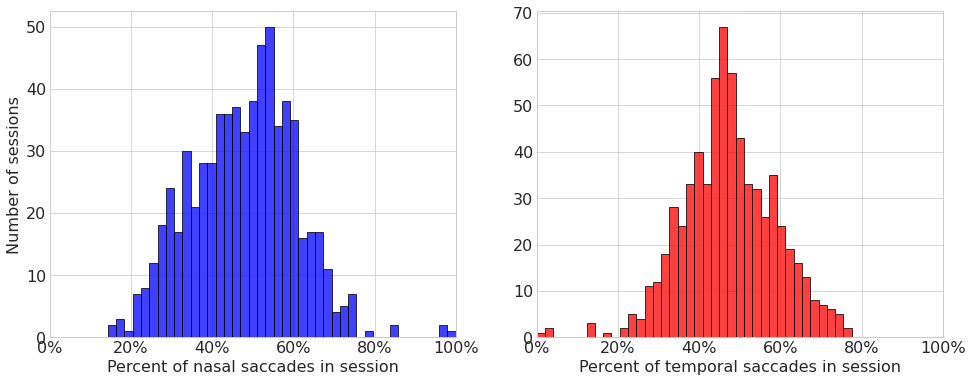

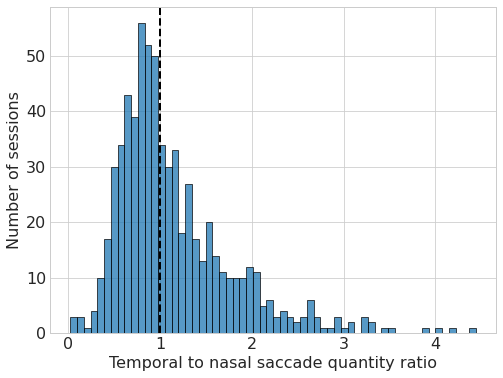

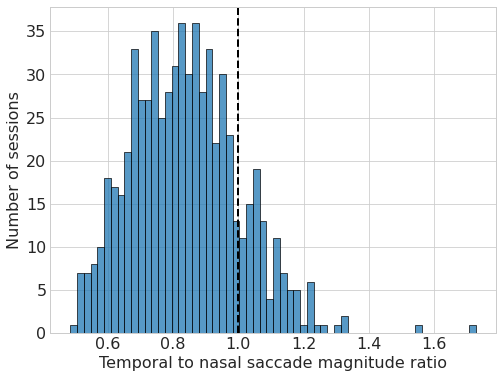

In [16]:
with plt.style.context("seaborn-whitegrid"):
    fig, axs = plt.subplots(ncols=2, figsize=(16, 6), facecolor="white")
    bins = np.linspace(0, 1, 50)
    ylabel = True

    for ax, dist, dir, color in zip(axs, (frac_N, frac_T), ("nasal", "temporal"), ("b", "r")):
        sns.histplot(dist, ax=ax, bins=bins, color=color)
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
        # ax.set_yticklabels(["", *[l.get_text() for l in ax.get_yticklabels()[1:]]])
        plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
        ax.set_xlabel(f"Percent of {dir} saccades in session", fontsize=16)
        if ylabel:
            ax.set_ylabel("Number of sessions", fontsize=16)
            ylabel = False
        else:
            ax.set_ylabel("")
        
        print(f"{dir}: {np.mean(dist)*100:.2f}% ± {np.std(dist)*100:.2f}%")
    savefig(fig, "pct_n_t_in_sessions.png")

    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    quantity_ratio = np.array([t/n for t, n in zip(frac_T, frac_N)])
    sns.histplot(quantity_ratio, ax=ax, bins=60)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    ax.set_xlabel(f"Temporal to nasal saccade quantity ratio", fontsize=16)
    ax.set_ylabel("Number of sessions", fontsize=16)
    ax.axvline(1, color="black", linestyle="dashed", linewidth=2)
    savefig(fig, "temporal_to_nasal_num_ratio.png")
    print(f"T:N quantity {np.mean(quantity_ratio):.2f} ± {np.std(quantity_ratio):.2f} (median = {np.median(quantity_ratio):.2f})")
    print(f"{np.mean(quantity_ratio < 1)*100:.1f} {np.mean(quantity_ratio > 1)*100:.1f}")

    # fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    # ax.scatter(frac_N, frac_T)
    # ax.axis("equal")
    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 1)

    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    sns.histplot(mag_ratio, ax=ax, bins=60)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    ax.set_xlabel(f"Temporal to nasal saccade magnitude ratio", fontsize=16)
    ax.set_ylabel("Number of sessions", fontsize=16)
    ax.axvline(1, color="black", linestyle="dashed", linewidth=2)
    savefig(fig, "temporal_to_nasal_mag_ratio.png")
    print(f"T:N magnitude {np.mean(mag_ratio):.2f} ± {np.std(mag_ratio):.2f}")
    

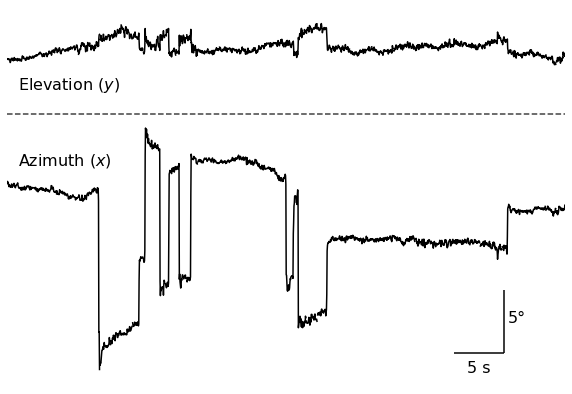

In [17]:
data = load_data_by_session_id(696717748)

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
saccades = data["saccades"]
# mid = saccades[len(saccades)//2][0]
mid = saccades[30][0]
start, end = mid-30*15, mid+30*40

eye_tracking = data["eye_tracking"]

ax.plot(eye_tracking["x_pos_deg"].loc[start:end], color="black")
ax.plot(eye_tracking["y_pos_deg"].loc[start:end], color="black")
ax.axhline(0, color="black", linestyle="dashed", alpha=0.75)

ax.annotate("Elevation ($y$)", (start+(end-start)*0.02, 2), color="black", fontsize=16)
ax.annotate("Azimuth ($x$)", (start+(end-start)*0.02, -4), color="black", fontsize=16)

hscale_width = 30*5
hscale_start = start + (end-start)*0.8
hscale_y = -19
vscale_height = 5
ax.hlines(hscale_y, xmin=hscale_start, xmax=hscale_start+hscale_width, color="black")
ax.annotate("5 s", (hscale_start+hscale_width//2, hscale_y-1.5), ha="center", fontsize=16)
ax.vlines(hscale_start+hscale_width, ymin=hscale_y, ymax=hscale_y+vscale_height, color="black")
ax.annotate(f"{vscale_height}°", (hscale_start+hscale_width+10, hscale_y+vscale_height/2), ha="left", fontsize=16)
ax.set_xlim(start, end)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

savefig(fig, "sample_eye_traces.png")

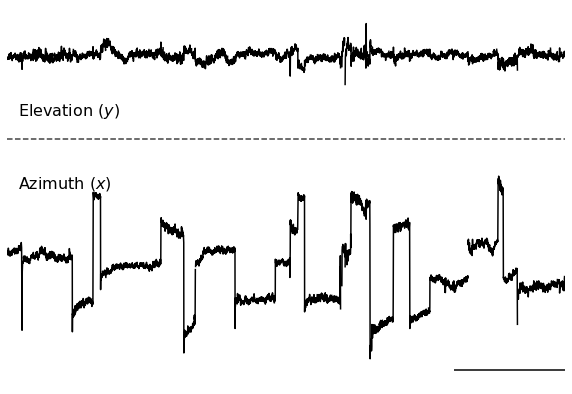

In [18]:
# Generate figure of sample eye position traces

data = load_data_by_session_id(696717748)

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
saccades = data["saccades"]
# mid = saccades[len(saccades)//2][0]
start, end = 10000, 15000

eye_tracking = data["eye_tracking"]

ax.plot(eye_tracking["x_pos_deg"].loc[start:end], color="black")
ax.plot(eye_tracking["y_pos_deg"].loc[start:end], color="black")
ax.axhline(0, color="black", linestyle="dashed", alpha=0.75)

ax.annotate("Elevation ($y$)", (start+(end-start)*0.02, 2), color="black", fontsize=16)
ax.annotate("Azimuth ($x$)", (start+(end-start)*0.02, -4), color="black", fontsize=16)

hscale_width = 30*60*3
hscale_start = start + (end-start)*0.8
hscale_y = -19
vscale_height = 5
ax.hlines(hscale_y, xmin=hscale_start, xmax=hscale_start+hscale_width, color="black")
ax.annotate("5 s", (hscale_start+hscale_width//2, hscale_y-1.5), ha="center", fontsize=16)
ax.vlines(hscale_start+hscale_width, ymin=hscale_y, ymax=hscale_y+vscale_height, color="black")
ax.annotate(f"{vscale_height}°", (hscale_start+hscale_width+10, hscale_y+vscale_height/2), ha="left", fontsize=16)
ax.set_xlim(start, end)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

savefig(fig, "sample_eye_traces.png")

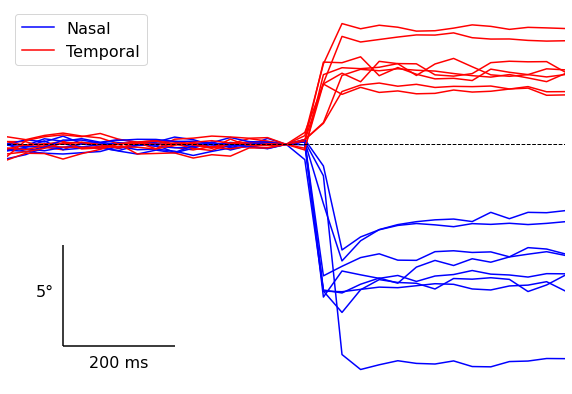

In [19]:
fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")

n_nasal, n_temporal = 0, 0
n_to_plot = 8
r = 15

for ss, se in saccades:
    mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
    trace = eye_tracking["x_pos_deg"].loc[ss-r:ss+r]
    trace -= trace.loc[ss]
    trace = trace.values

    if np.any(np.isnan(trace)):
        continue

    if dir == "L" and n_nasal < n_to_plot:
        n_nasal += 1
        ax.plot(trace, color="blue")
    elif dir == "R" and n_temporal < n_to_plot:
        n_temporal += 1
        ax.plot(trace, color="red")

ax.axhline(0, color="black", linestyle="dashed", linewidth=1)
ax.set_xlim(0, 2*r)

hscale_width = 30*0.2
hscale_start = 3
hscale_y = -10
vscale_height = 5
ax.hlines(hscale_y, xmin=hscale_start, xmax=hscale_start+hscale_width, color="black")
ax.annotate("200 ms", (hscale_start+hscale_width//2, hscale_y-1), ha="center", fontsize=16)
ax.vlines(hscale_start, ymin=hscale_y, ymax=hscale_y+vscale_height, color="black")
ax.annotate(f"{vscale_height}°", (hscale_start-0.5, hscale_y+vscale_height/2), ha="right", fontsize=16)

legend_handles = [
    Line2D([0], [0], color="blue", label="Nasal"),
    Line2D([0], [0], color="red", label="Temporal"),
]
ax.legend(handles=legend_handles, fontsize=16)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

savefig(fig, "sample_nasal_temporal_saccades.png")

In [20]:
df_saccades.head()

,cre_line,cre_abbrev,specimen_name,stim,duration,direction,magnitude,peak_speed,mean_running_speed,mean_pupil_area,dx
0,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_4deg,0.100000,L,0.128292,70.011660,0.002462,0.003900,-0.126131
1,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,4.511047,64.262569,-0.001165,0.004208,4.458092
2,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.133333,R,3.013002,44.197989,-0.266592,0.005606,2.957298
3,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,L,9.012816,133.702206,-0.350692,0.009126,-8.981052
4,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,6.400596,88.736315,0.971764,0.007928,6.381285


195158 6.6509571387603605 ± 3.045052470744621


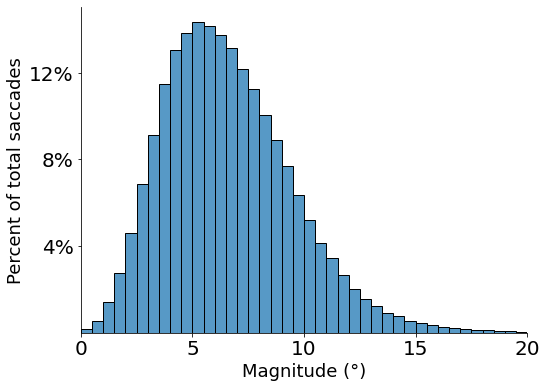

In [21]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

xmin, xmax = 0, 20
mags = df_saccades["magnitude"].values[mask_L_saccades | mask_R_saccades]
sns.histplot(mags, bins=np.arange(xmin, xmax+0.5, 0.5), stat="density")
# ax.hist(df_saccades["magnitude"].values[mask_L_saccades | mask_R_saccades], bins=np.arange(xmin, xmax+0.5, 0.5), color="black", density=True)
# ax.set_title("Saccades magnitudes", fontsize=18)
ax.set_xlabel("Magnitude (°)", fontsize=18)
ax.set_ylabel("Percent of total saccades", fontsize=18)
plt.setp(ax.get_xticklabels(), fontsize=20)
ax.set_yticks([0.04, 0.08, 0.12])
ax.set_yticklabels(["4%", "8%", "12%"], fontsize=20)
xticks = np.arange(0, 20+5, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlim(xmin, xmax)
savefig(fig, "saccade_magnitudes.png")

print(len(mags), mags.mean(), "±", mags.std())

In [33]:
inter_saccade_intervals = []
for data in load_data(tqdm_desc="Computing inter-saccade intervals"):
    saccades = data["saccades"]
    cre = data["session_data"]["cre_line"]
    for i in range(1, len(saccades)):
        mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], *saccades[i])

        inter_saccade_intervals.append({
            "cre": cre,
            "reporter": match_cre_line(data).reporter,
            "interval": (saccades[i][0] - saccades[i-1][1]) / 30,
            "dir": dir,
            # "stim": get_stim_at_frame(data["stim_epoch"], saccades[i][0]),
        })

inter_saccade_intervals = pd.DataFrame(inter_saccade_intervals)

Computing inter-saccade intervals:   0%|          | 0/818 [00:00<?, ?it/s]

In [34]:
stats.ks_2samp(inter_saccade_intervals["interval"][inter_saccade_intervals["reporter"] == "Ai93"], inter_saccade_intervals["interval"][inter_saccade_intervals["reporter"] == "Ai148"])

KstestResult(statistic=0.08584406127131239, pvalue=1.501194144190813e-297)

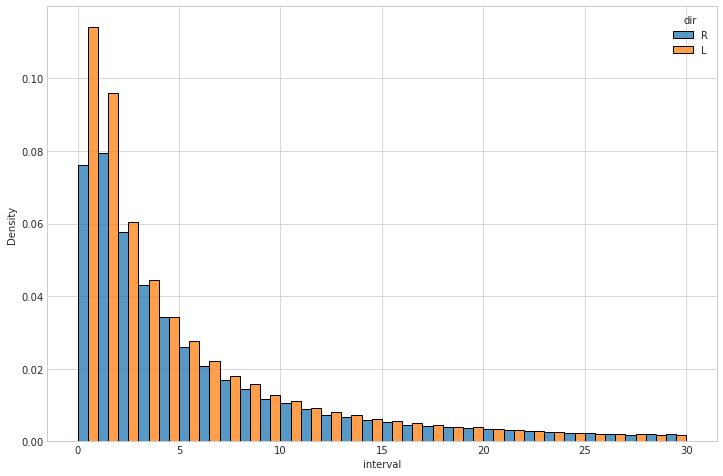

In [35]:
with plt.style.context("seaborn-whitegrid"):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=inter_saccade_intervals[(inter_saccade_intervals["dir"] == "L") | (inter_saccade_intervals["dir"] == "R")], x="interval", hue="dir", multiple="dodge", bins=np.arange(0, 31, 1), stat="density")

In [36]:
mask = inter_saccade_intervals["interval"] > 2
inter_saccade_intervals["dir"][mask].value_counts()

L    65265
R    63244
D     3569
U     1877
Name: dir, dtype: int64

In [37]:
inter_saccade_intervals["interval"].median()

3.7666666666666666

67411 0.33476853093372266


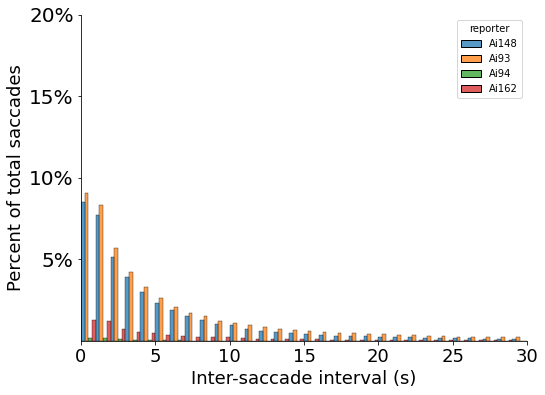

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

print(np.sum(np.array(inter_saccade_intervals["interval"]) <= 2), np.mean(np.array(inter_saccade_intervals["interval"]) <= 2))

sns.histplot(data=inter_saccade_intervals, x="interval", hue="reporter", multiple="dodge", bins=np.arange(0, 31, 1), stat="density")
# ax.hist(df_saccades["magnitude"].values[mask_L_saccades | mask_R_saccades], bins=np.arange(xmin, xmax+0.5, 0.5), color="black", density=True)
# ax.set_title("Saccades magnitudes", fontsize=18)
ax.set_xlabel("Inter-saccade interval (s)", fontsize=18)
ax.set_ylabel("Percent of total saccades", fontsize=18)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=18)
ax.set_yticks([0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(["5%", "10%", "15%", "20%"], fontsize=20)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks, fontsize=20)
ax.set_xlim(0, 30)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
savefig(fig, "inter_saccade_intervals.png")

# print(len(mags), mags.mean(), "±", mags.std())

In [40]:
# fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
# sns.histplot(data=inter_saccade_intervals[inter_saccade_intervals["stim"] == "spontaneous"], x="interval", bins=np.arange(0, 31, 1), stat="density", multiple="dodge")
# sns.histplot(inter_saccade_intervals_T, bins=np.arange(0, 31, 1), color="r", stat="density")

In [41]:
df_saccades.head()

,cre_line,cre_abbrev,specimen_name,stim,duration,direction,magnitude,peak_speed,mean_running_speed,mean_pupil_area,dx
0,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_4deg,0.100000,L,0.128292,70.011660,0.002462,0.003900,-0.126131
1,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,4.511047,64.262569,-0.001165,0.004208,4.458092
2,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.133333,R,3.013002,44.197989,-0.266592,0.005606,2.957298
3,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,L,9.012816,133.702206,-0.350692,0.009126,-8.981052
4,Sst; Ai148,Sst; Ai148,Sst-IRES-Cre;Ai148(CAM)-306506,locally_sparse_noise_8deg,0.100000,R,6.400596,88.736315,0.971764,0.007928,6.381285


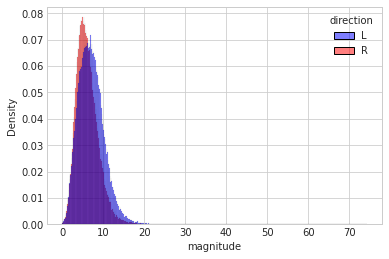

In [42]:
with plt.style.context("seaborn-whitegrid"):
    sns.histplot(df_saccades[mask_L_saccades | mask_R_saccades], x="magnitude", hue="direction", stat="density", palette={"L": "blue", "R": "red", "D": "gray", "U": "gray"})

Nasal saccades (n = 104,121): 7.10 ± 3.19
Temporal saccades (n = 91,037): 6.14 ± 2.78
KstestResult(statistic=0.1556933593970361, pvalue=0.0)


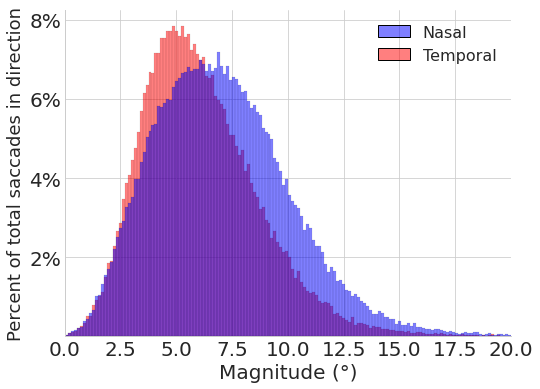

In [43]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

    sns.histplot(df_saccades[mask_L_saccades | mask_R_saccades], x="magnitude", hue="direction", stat="density", palette={"L": "blue", "R": "red", "D": "gray", "U": "gray"})
    # ax.hist(df_saccades["magnitude"].values[mask_L_saccades | mask_R_saccades], bins=np.arange(xmin, xmax+0.5, 0.5), color="black", density=True)
    # ax.set_title("Saccades magnitudes", fontsize=18)
    # ax.set_xlabel("$\Delta \, x$ (°)", fontsize=20)
    ax.set_xlabel("Magnitude (°)", fontsize=20)
    ax.set_ylabel("Percent of total saccades in direction", fontsize=18)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    yticks = [0.02, 0.04, 0.06, 0.08]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{x*100:.0f}%" for x in yticks], fontsize=20)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlim(0, 20)

    ax.legend(handles=ax.legend_.legendHandles, labels=["Nasal", "Temporal"], fontsize=16)
    savefig(fig, "saccade_mag_by_dir.png")

    print(f"Nasal saccades (n = {mask_L_saccades.sum():,}): {df_saccades[mask_L_saccades]['magnitude'].mean():.2f} ± {df_saccades[mask_L_saccades]['magnitude'].std():.2f}")
    print(f"Temporal saccades (n = {mask_R_saccades.sum():,}): {df_saccades[mask_R_saccades]['magnitude'].mean():.2f} ± {df_saccades[mask_R_saccades]['magnitude'].std():.2f}")

    # two-sample Kolmogorov-Smirnov
    print(stats.ks_2samp(df_saccades[mask_L_saccades]['magnitude'], df_saccades[mask_R_saccades]['magnitude']))

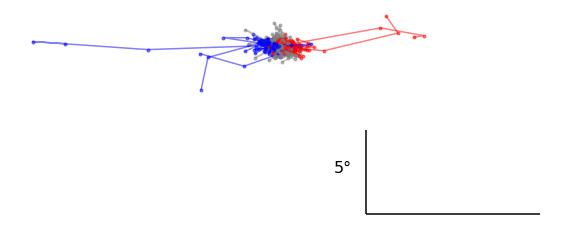

In [51]:
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")

for ss, se in saccades:
    # print(dir, get_degrees_moved(eye_tracking, ss, se))
    x = eye_tracking["x_pos_deg"].loc[ss:se].values
    y = eye_tracking["y_pos_deg"].loc[ss:se].values
    if len(x) == 0: continue # No data
    x -= x[0]
    y -= y[0]

    mag, dir = get_saccade_magnitude_direction(eye_tracking, ss, se)
    
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        continue
    elif mag > 20:
        continue

    ax.plot(x, y, marker=".", color=("red" if dir == "R" else "blue" if dir == "L" else "gray"), alpha=0.5)

# ax.axhline(0, color="black", linestyle="dashed", linewidth=1)
# ax.set_xlim(0, 2*r)

hscale_width = 30*0.2
hscale_start = 3
hscale_y = -10
vscale_height = 5
ax.hlines(hscale_y, xmin=hscale_start, xmax=hscale_start+hscale_width, color="black")
ax.annotate("200 ms", (hscale_start+hscale_width//2, hscale_y-1), ha="center", fontsize=16)
ax.vlines(hscale_start, ymin=hscale_y, ymax=hscale_y+vscale_height, color="black")
ax.annotate(f"{vscale_height}°", (hscale_start-0.5, hscale_y+vscale_height/2), ha="right", fontsize=16)

# legend_handles = [
#     Line2D([0], [0], color="blue", label="Nasal", lw=3, marker=".", markersize=15),
#     Line2D([0], [0], color="red", label="Temporal", lw=3, marker=".", markersize=15),
#     Line2D([0], [0], color="gray", label="Other", lw=3, marker=".", markersize=15),
# ]
# ax.legend(handles=legend_handles, fontsize=16)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# savefig(fig, "sample_saccade_motions.png")

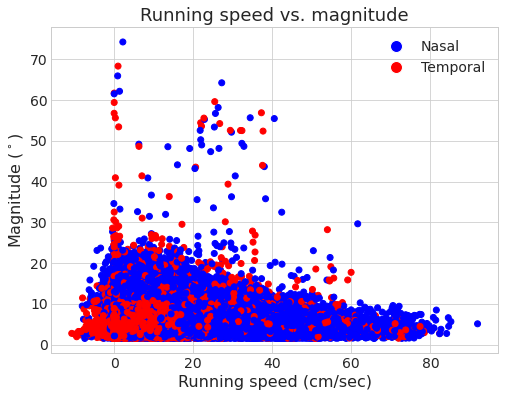

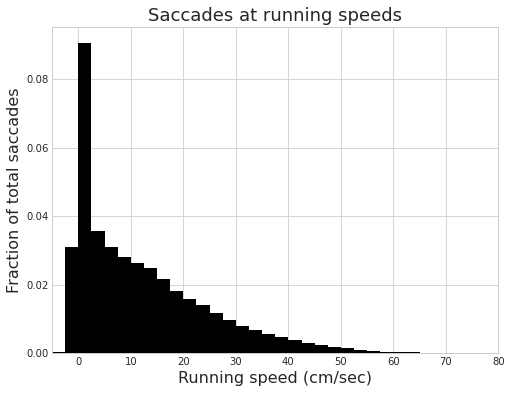

In [52]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    color = np.where(mask_L_saccades, "blue", np.where(mask_R_saccades, "red", ""))
    mask = (mask_L_saccades | mask_R_saccades) & (df_saccades["magnitude"].values > 1.5)
    color = color[mask]
    ax.scatter(df_saccades["mean_running_speed"].values[mask], df_saccades["magnitude"].values[mask], color=color)
    # ax.scatter(df_saccades["magnitude"].values[mask_L_saccades], df_saccades["peak_speed"].values[mask_L_saccades], color="blue", label="Nasal")
    # ax.scatter(df_saccades["magnitude"].values[mask_R_saccades], df_saccades["peak_speed"].values[mask_R_saccades], color="red", label="Temporal")

    legend_handles = [
        Line2D([0], [0], color="white", marker="o", markersize=12, label="Nasal", markerfacecolor="blue"),
        Line2D([0], [0], color="white", marker="o", markersize=12, label="Temporal", markerfacecolor="red"),
    ]
    ax.legend(handles=legend_handles, fontsize=14)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
    ax.set_title("Running speed vs. magnitude", fontsize=18)
    ax.set_xlabel("Running speed (cm/sec)", fontsize=16)
    ax.set_ylabel("Magnitude ($^\circ$)", fontsize=16)
    # ax.set_xlim(0, 35)
    # ax.set_ylim(0, 1000)

    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    ax.hist(df_saccades["mean_running_speed"].values[mask_L_saccades | mask_R_saccades], bins=np.arange(-10, 80+2.5, 2.5), color="black", density=True)
    ax.set_title("Saccades at running speeds", fontsize=18)
    ax.set_xlabel("Running speed (cm/sec)", fontsize=16)
    ax.set_ylabel("Fraction of total saccades", fontsize=16)
    ax.set_xlim(-5, 80)

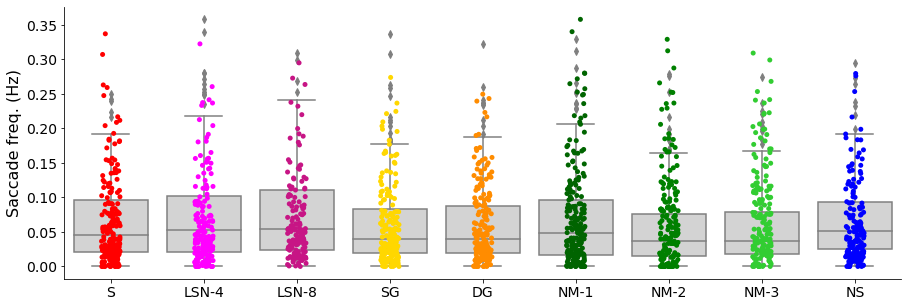

In [55]:
# Number of saccades in each stimulus type
fig, ax = plt.subplots(figsize=(15, 5), facecolor="white")

# Group by mouse
df = df_stim.groupby(["specimen_name", "stim_abbrev"], as_index=False)["mean_sacc_per_sec"].mean()
sns.boxplot(data=df, x="stim_abbrev", y="mean_sacc_per_sec", color="lightgray", ax=ax)
sns.stripplot(data=df, x="stim_abbrev", y="mean_sacc_per_sec", palette=STIM_COLORS, order=STIM_ORDERING, ax=ax)

# sns.boxplot(data=df_stim, x="stim_abbrev", y="mean_sacc_per_sec", color="lightgray", ax=ax)
# sns.stripplot(data=df_stim, x="stim_abbrev", y="mean_sacc_per_sec", palette=STIM_COLORS, order=STIM_ORDERING, ax=ax)

plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
# ax.set_title("Saccade frequency for different visual stimuli", fontsize=16)
ax.set_xlabel("", fontsize=16)
ax.set_ylabel("Saccade freq. (Hz)", fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
savefig(fig, "saccade_freq_stim.png")

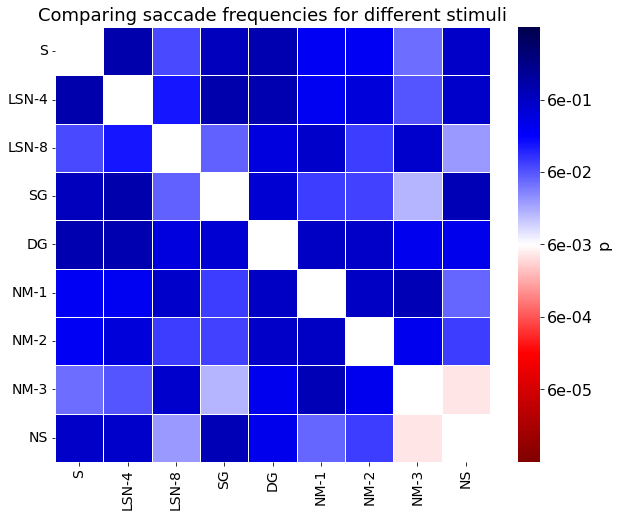

In [56]:
n = len(STIM_ORDERING)
p_matrix = np.zeros((n, n), dtype=float)
heatmap_labels = np.zeros((n, n), dtype=object)
heatmap_labels[:] = ""

for i in range(n):
    p_matrix[i,i] = np.nan
    for j in range(i+1, n):
        a = df["mean_sacc_per_sec"].values[df["stim_abbrev"] == STIM_ORDERING[i]]
        b = df["mean_sacc_per_sec"].values[df["stim_abbrev"] == STIM_ORDERING[j]]
        p_val = stats.ks_2samp(a, b)[1]
        p_matrix[i,j] = p_matrix[j,i] = p_val

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=STIM_ORDERING, title="Comparing saccade frequencies for different stimuli")
savefig(fig, "sacc_freq_stim_proba.png")

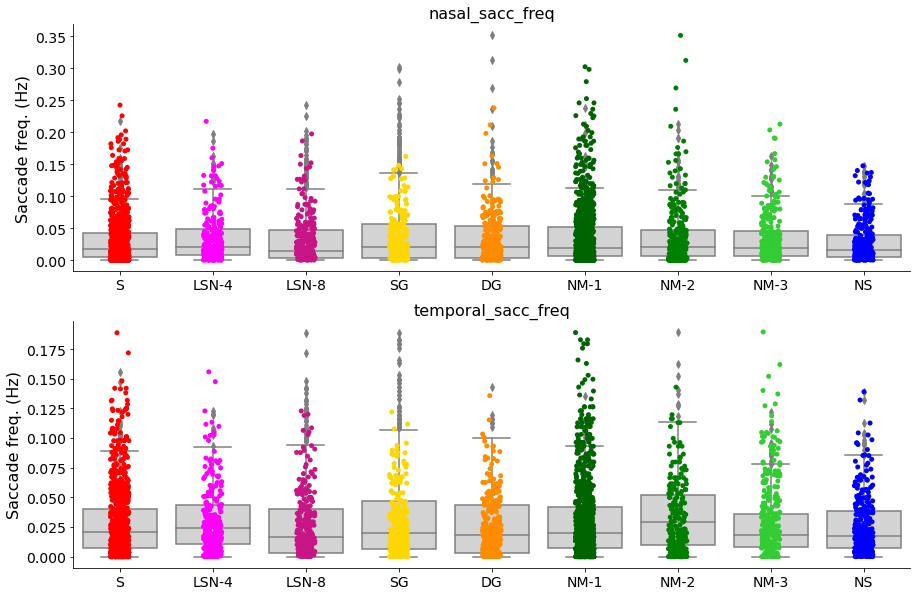

In [57]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10), facecolor="white")

for ax, key in zip(axs, ["nasal_sacc_freq", "temporal_sacc_freq"]):
    sns.boxplot(data=df_stim, x="stim_abbrev", y=key, color="lightgray", ax=ax)
    sns.stripplot(data=df_stim, x="stim_abbrev", y=key, palette=STIM_COLORS, order=STIM_ORDERING, ax=ax)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
    ax.set_xlabel("", fontsize=16)
    ax.set_ylabel("Saccade freq. (Hz)", fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(key, fontsize=16)
    # ax.set_ylim(-1, 16)

savefig(fig, "saccade_freq_stim_by_dir.png")

In [58]:
for stim_abbrev in df_stim["stim_abbrev"].unique():
    stim_mask = df_stim["stim_abbrev"] == stim_abbrev
    _, p = stats.ranksums(df_stim["nasal_sacc_freq"][stim_mask], df_stim["temporal_sacc_freq"][stim_mask])
    print(f"{stim_abbrev}: p = {p:.4f}")

LSN-4: p = 0.7799
LSN-8: p = 0.6190
S: p = 0.6810
NM-1: p = 0.9115
NM-2: p = 0.2973
DG: p = 0.6075
NM-3: p = 0.0694
SG: p = 0.9094
NS: p = 0.5069


,mean,sd
cre_abbrev,,
Fezf2; Ai148,24.608153,13.641233
Tlx3; Ai148,22.669061,16.164071
Vip; Ai148,10.360144,10.408748
Ntsr1; Ai148,8.790656,11.586693
Pvalb; Ai162,7.651797,9.244064
Rbp4; Ai93,7.195882,9.019556
Cux2; Ai93,7.036858,9.704810
Slc17a7; Ai93,6.606403,9.998562
Rorb; Ai93,5.429284,9.029405


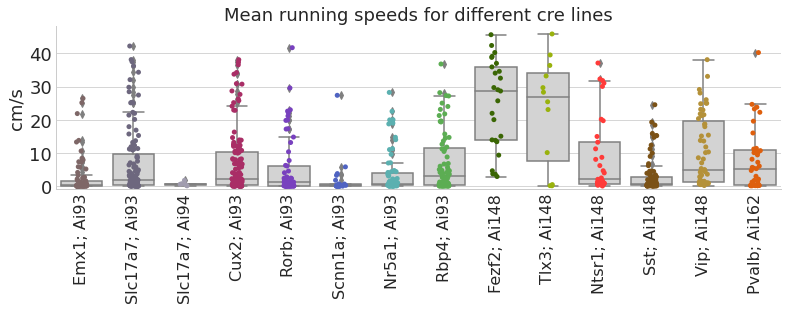

In [59]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(13, 3), facecolor="white")
    sns.boxplot(data=df_experiments, x="cre_abbrev", y="mean_running_speed", color="lightgray", order=CRE_ORDERING, ax=ax)
    sns.stripplot(data=df_experiments, x="cre_abbrev", y="mean_running_speed", palette=CRE_COLORS, order=CRE_ORDERING, ax=ax)
    plt.setp(ax.get_xticklabels(), fontsize=16, rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_title("Mean running speeds for different cre lines", fontsize=18)
    # plt.setp(ax.get_xticklabels(), fontsize=18, rotation=45)
    # ax.set_xticklabels(["\n".join(CRE_ABBREV[abbrev].split("-", 1)) for abbrev in CRE_LINE_ORDERING], fontsize=16, rotation=90)
    # ax.set_xlabel("Cre line", fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("cm/s", fontsize=18)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylim(-1, ax.get_ylim()[1])
    savefig(fig, "mean_run_speed_by_cre.png")

df_experiments.groupby("cre_abbrev")["mean_running_speed"].agg(mean="mean", sd="std").sort_values("mean", ascending=False)

,mean,sd
cre_abbrev,,
Tlx3; Ai148,0.147303,0.076602
Fezf2; Ai148,0.122212,0.060368
Vip; Ai148,0.117686,0.073838
Ntsr1; Ai148,0.116923,0.063448
Pvalb; Ai162,0.090219,0.044564
Sst; Ai148,0.072809,0.053541
Rbp4; Ai93,0.062725,0.068060
Slc17a7; Ai94,0.057388,0.024199
Nr5a1; Ai93,0.054907,0.066122


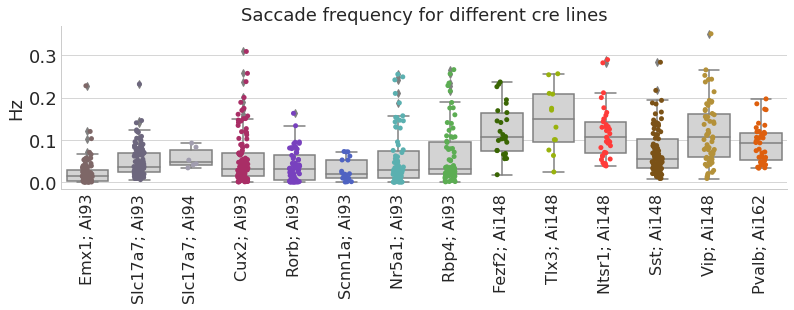

In [60]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(13, 3), facecolor="white")
    sns.boxplot(data=df_experiments, x="cre_abbrev", y="mean_sacc_per_sec", color="lightgray", order=CRE_ORDERING, ax=ax)
    sns.stripplot(data=df_experiments, x="cre_abbrev", y="mean_sacc_per_sec", palette=CRE_COLORS, order=CRE_ORDERING, ax=ax)
    plt.setp(ax.get_xticklabels(), fontsize=16, rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    # ax.set_xticklabels([x.replace("; ", "\n") for x in CRE_ORDERING], fontsize=16, rotation=0)
    ax.set_title("Saccade frequency for different cre lines", fontsize=18)
    # ax.set_xlabel("Cre line", fontsize=16)
    ax.set_ylabel("Hz", fontsize=18)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_ylim(-1, 1280)
    # ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
    # ax.set_yticklabels([0, None, 0.1, None, 0.2, None, 0.3, None])
    ax.set_yticks([0, .1, .2, .3])
    savefig(fig, "sacc_freq_cre.png")

df_experiments.groupby("cre_abbrev")["mean_sacc_per_sec"].agg(mean="mean", sd="std").sort_values("mean", ascending=False)

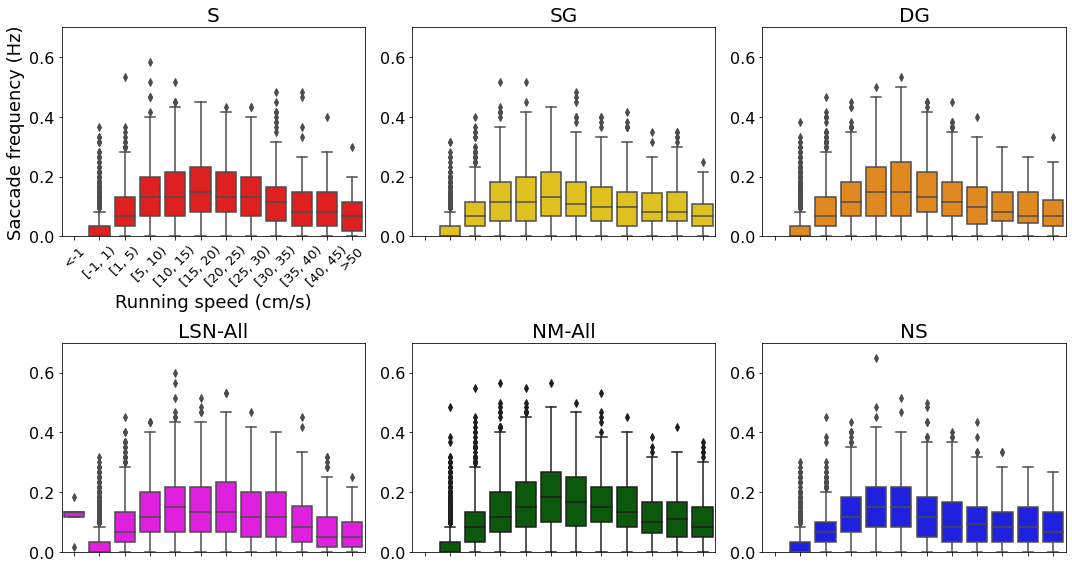

In [61]:
# Form data into df
bins = [-1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
bin_labels = []
for i, x in enumerate(bins):
    if i == 0:
        label = f"<{x}"
    elif i == len(bins) - 1:
        label = f">{x}"
    else:
        label = f"[{bins[i-1]}, {x})"
    bin_labels.append(label)

def label_run_speed_bin(row):
    run_speed = row["mean_running_speed"]
    for i, x in enumerate(bins):
        if run_speed < x:
            return bin_labels[i]
    return bin_labels[-1]

def get_stim_type_agg(row):
    stim = STIM_ABBREV[row["stim"]]
    if "-" in stim:
        return stim[:stim.rindex("-")] + "-All"
    return stim

df_binned["speed_bin"] = df_binned.apply(label_run_speed_bin, axis=1)
df_binned["stim_agg"] = df_binned.apply(get_stim_type_agg, axis=1)

fig = plt.figure(figsize=(15, 8), facecolor="white")
# fig.suptitle("Mean running speed and saccade frequency by stimulus type", fontsize=24)

for i, stim_type in enumerate(["S", "SG", "DG", "LSN-All", "NM-All", "NS"]): # df_binned["stim_agg"].unique()
    ax = fig.add_subplot(2, 3, i+1)
    df_sub = df_binned[df_binned["stim_agg"] == stim_type]
    sns.boxplot(data=df_sub, x="speed_bin", y="mean_sacc_per_sec", order=bin_labels, ax=ax, color=STIM_COLORS[stim_type])
    ax.set_ylim(0, 0.7)
    ax.set_title(f"{stim_type}", fontsize=20)
    ax.tick_params(axis="y", labelsize=16)
    
    if i == 0:
        ax.set_xlabel("Running speed (cm/s)", fontsize=18)
        ax.set_ylabel("Saccade frequency (Hz)", fontsize=18)
        ax.tick_params(axis="x", rotation=45, labelsize=13)
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels([])

fig.tight_layout()

In [63]:
df_experiments.head()

,cre_line,cre_abbrev,mean_running_speed,fraction_running,mean_pupil_area,n_saccades,mean_sacc_per_sec,sex,age,duration_seconds,specimen_name
0,Sst; Ai148,Sst; Ai148,1.034260,0.284916,0.004829,130,0.031692,female,128,4102.033333,Sst-IRES-Cre;Ai148(CAM)-306506
1,Emx1; Ai93,Emx1; Ai93,0.036859,0.018307,0.001036,2,0.000523,female,118,3825.400000,Emx1-IRES-Cre;Camk2a-tTA;Ai93-276948
2,Cux2; Ai93,Cux2; Ai93,0.102920,0.034720,0.002365,4,0.001046,male,83,3824.833333,Cux2-CreERT2;Camk2a-tTA;Ai93-233215
3,Ntsr1; Ai148,Ntsr1; Ai148,31.010494,0.975698,0.003941,508,0.131197,female,83,3872.033333,Ntsr1-Cre_GN220;Ai148-370773
4,Slc17a7; Ai94,Slc17a7; Ai94,0.087120,0.040507,0.002051,178,0.043383,female,93,4103.000000,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111


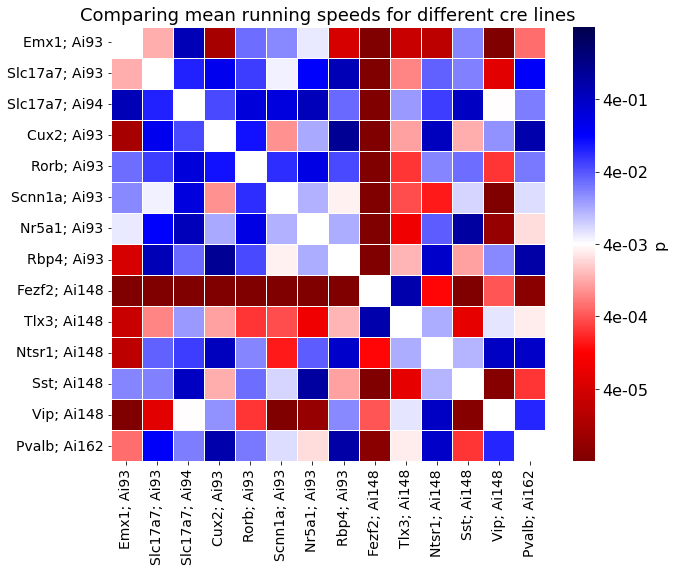

In [64]:
n_cre = len(CRE_ORDERING)
p_matrix = np.zeros((n_cre, n_cre), dtype=float)
heatmap_labels = np.zeros((n_cre, n_cre), dtype=object)
heatmap_labels[:] = ""

for i in range(n_cre):
    p_matrix[i,i] = np.nan
    for j in range(i+1, n_cre):
        a = df_experiments["mean_running_speed"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[i]]
        b = df_experiments["mean_running_speed"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[j]]
        # p_val = stats.ttest_ind(a, b)[1]
        p_val = stats.kstest(a, b)[1]
        p_matrix[i,j] = p_matrix[j,i] = p_val
        # if p_val < 0.05:
        #     heatmap_labels[i,j] = heatmap_labels[j,i] = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title="Comparing mean running speeds for different cre lines")
savefig(fig, "p_matrix_cre_mean_run.png")

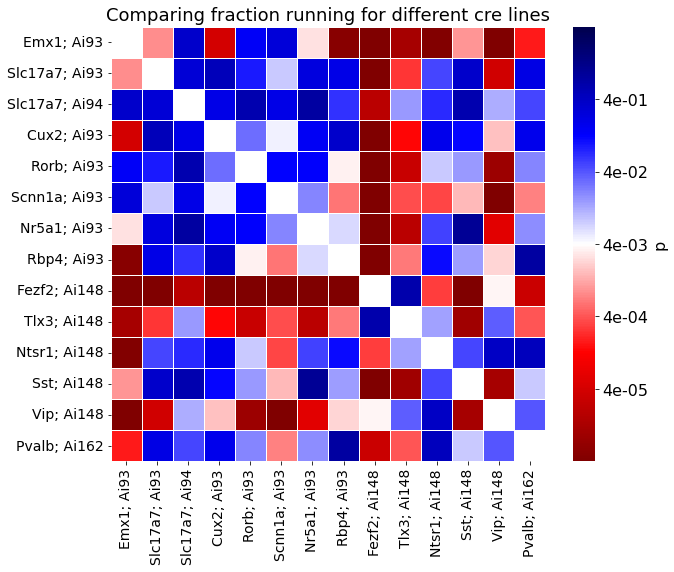

In [65]:
n_cre = len(CRE_ORDERING)
p_matrix = np.zeros((n_cre, n_cre), dtype=float)
heatmap_labels = np.zeros((n_cre, n_cre), dtype=object)
heatmap_labels[:] = ""

for i in range(n_cre):
    p_matrix[i,i] = np.nan
    for j in range(i+1, n_cre):
        a = df_experiments["fraction_running"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[i]]
        b = df_experiments["fraction_running"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[j]]
        # p_val = stats.ttest_ind(a, b)[1]
        p_val = stats.ks_2samp(a, b)[1]
        p_matrix[i,j] = p_matrix[j,i] = p_val
        # if p_val < 0.05:
        #     heatmap_labels[i,j] = heatmap_labels[j,i] = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title="Comparing fraction running for different cre lines")
savefig(fig, "p_matrix_cre_frac_run.png")

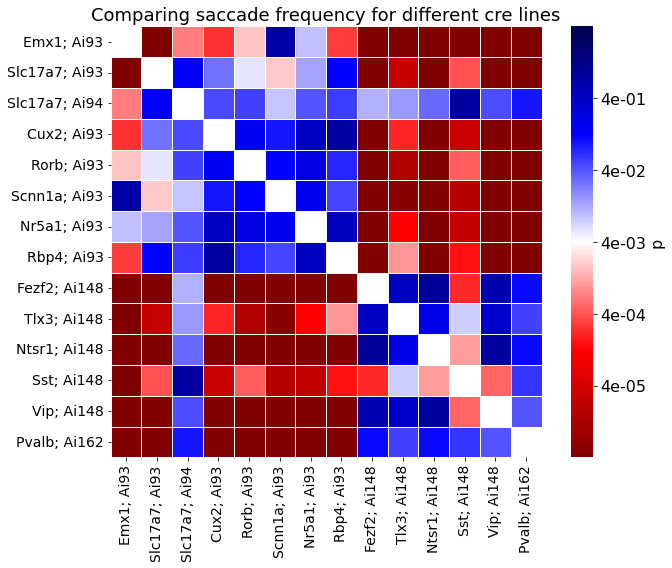

In [66]:
n_cre = len(CRE_ORDERING)
p_matrix = np.zeros((n_cre, n_cre), dtype=float)
heatmap_labels = np.zeros((n_cre, n_cre), dtype=object)
heatmap_labels[:] = ""

for i in range(n_cre):
    p_matrix[i,i] = np.nan
    for j in range(i+1, n_cre):
        a = df_experiments["mean_sacc_per_sec"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[i]]
        b = df_experiments["mean_sacc_per_sec"].values[df_experiments["cre_abbrev"] == CRE_ORDERING[j]]
        # p_val = stats.ttest_ind(a, b)[1]
        p_val = stats.ks_2samp(a, b)[1]
        p_matrix[i, j] = p_matrix[j, i] = p_val
        if p_val < 0.05:
            heatmap_labels[i, j] = heatmap_labels[j, i] = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title="Comparing saccade frequency for different cre lines")
fig.tight_layout()
savefig(fig, "p_matrix_cre_sacc_freq.png")

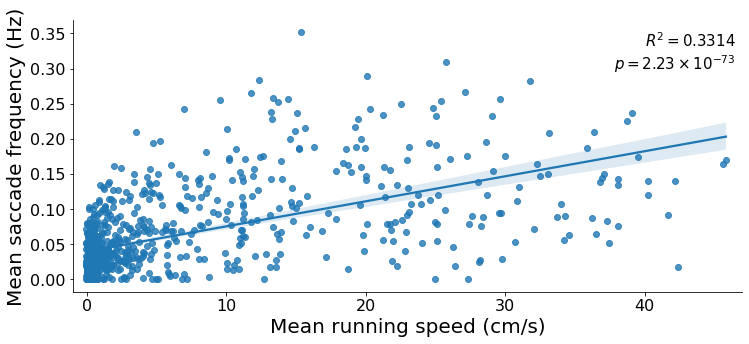

In [67]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")

x, y = "mean_running_speed", "mean_sacc_per_sec"
r, p = stats.pearsonr(df_experiments[x], df_experiments[y])

sns.regplot(data=df_experiments, x=x, y=y, ax=ax)
pstr = f"{p:.2e}".split("e")
r2_text = fr"$R^2 = {r**2:.4f}$"
p_text = fr"$p = {pstr[0]} \times 10^{'{' + pstr[1] + '}'}$"
ax.text(0.99, 0.96, f"{r2_text}\n{p_text}", ha="right", transform=ax.transAxes, fontsize=15, va="top")
ax.set_xlabel("Mean running speed (cm/s)", fontsize=20)
ax.set_ylabel("Mean saccade frequency (Hz)", fontsize=20)
# ax.set_title("Average running speed and number of saccades", fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(-1, 47)
savefig(fig, "mean_sacc_freq_vs_run.png")

In [68]:
df_experiments.head()

,cre_line,cre_abbrev,mean_running_speed,fraction_running,mean_pupil_area,n_saccades,mean_sacc_per_sec,sex,age,duration_seconds,specimen_name
0,Sst; Ai148,Sst; Ai148,1.034260,0.284916,0.004829,130,0.031692,female,128,4102.033333,Sst-IRES-Cre;Ai148(CAM)-306506
1,Emx1; Ai93,Emx1; Ai93,0.036859,0.018307,0.001036,2,0.000523,female,118,3825.400000,Emx1-IRES-Cre;Camk2a-tTA;Ai93-276948
2,Cux2; Ai93,Cux2; Ai93,0.102920,0.034720,0.002365,4,0.001046,male,83,3824.833333,Cux2-CreERT2;Camk2a-tTA;Ai93-233215
3,Ntsr1; Ai148,Ntsr1; Ai148,31.010494,0.975698,0.003941,508,0.131197,female,83,3872.033333,Ntsr1-Cre_GN220;Ai148-370773
4,Slc17a7; Ai94,Slc17a7; Ai94,0.087120,0.040507,0.002051,178,0.043383,female,93,4103.000000,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111


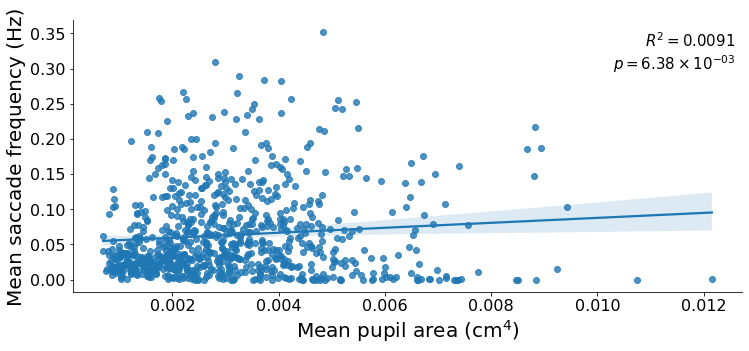

In [69]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")

x, y = "mean_pupil_area", "mean_sacc_per_sec"
r, p = stats.pearsonr(df_experiments[x], df_experiments[y])

sns.regplot(data=df_experiments, x=x, y=y, ax=ax)
pstr = f"{p:.2e}".split("e")
r2_text = fr"$R^2 = {r**2:.4f}$"
p_text = fr"$p = {pstr[0]} \times 10^{'{' + pstr[1] + '}'}$"
ax.text(0.99, 0.96, f"{r2_text}\n{p_text}", ha="right", transform=ax.transAxes, fontsize=15, va="top")
ax.set_xlabel("Mean pupil area (cm$^2$)", fontsize=20)
ax.set_ylabel("Mean saccade frequency (Hz)", fontsize=20)
# ax.set_title("Average running speed and number of saccades", fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.set_xlim(-1, 47)
savefig(fig, "mean_sacc_freq_vs_run.png")

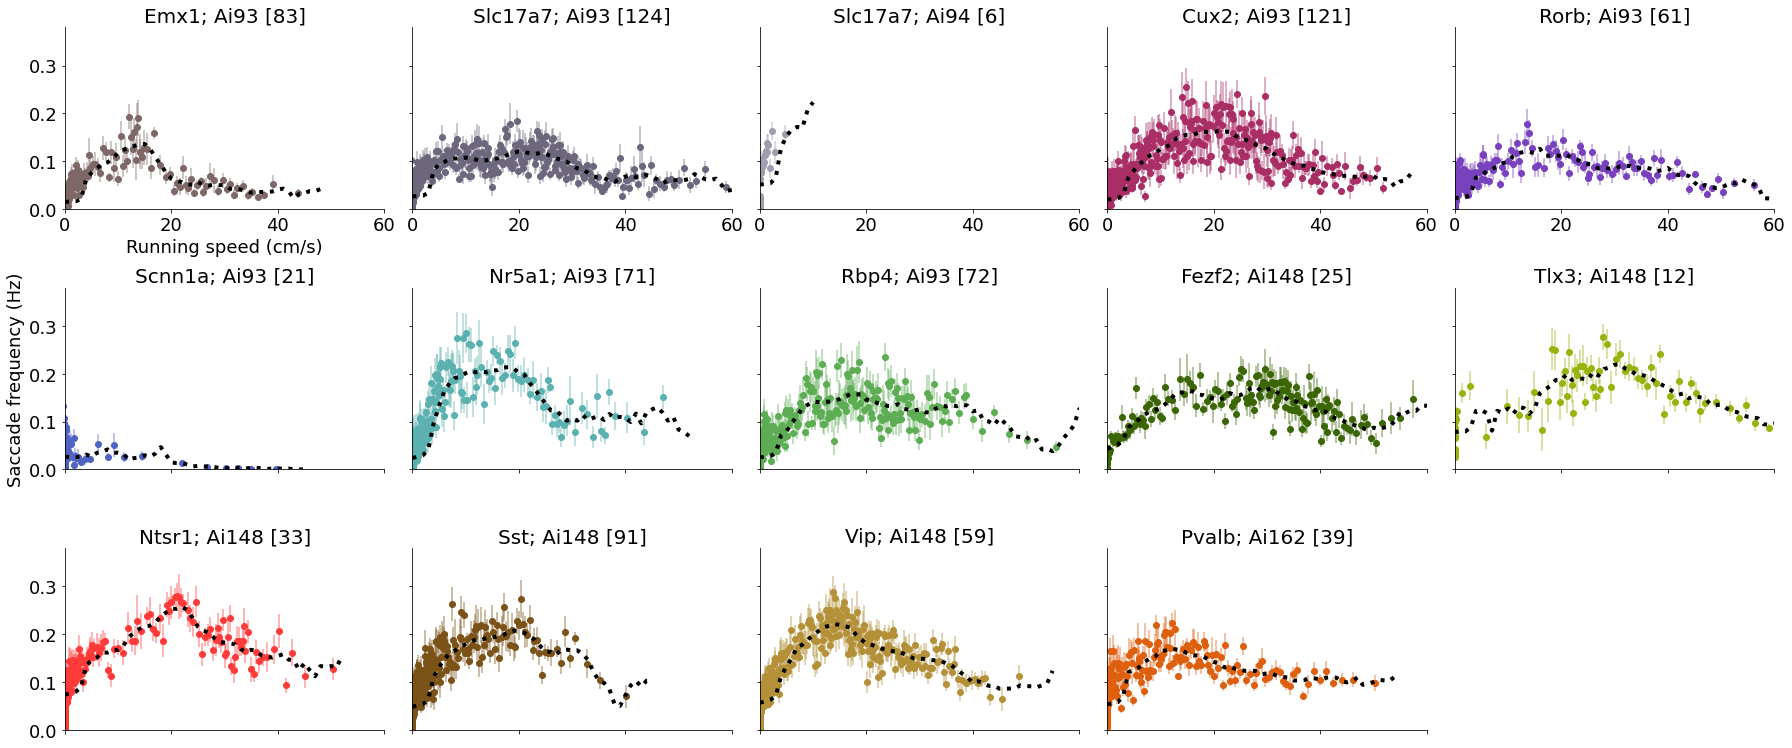

In [71]:
n_rows = 3
n_cols = 5
fig = plt.figure(figsize=(n_cols*5, n_rows*3.5), facecolor="white")
bin_size = 10

for plt_i, cre in enumerate(CRE_ORDERING):
    mask = df_binned["cre_abbrev"] == cre
    x_vals = df_binned["mean_running_speed"].values[mask]
    y_vals = df_binned["mean_sacc_per_sec"].values[mask]
    sort_idx = np.argsort(x_vals)
    x_vals[:] = x_vals[sort_idx]
    y_vals[:] = y_vals[sort_idx]

    x_plt = []
    y_plt = []
    y_err_plt = []

    for i in range(0, len(x_vals)-bin_size+1, bin_size):
        x = x_vals[i:i+bin_size].mean()
        y = y_vals[i:i+bin_size].mean()
        y_err = np.std(y_vals[i:i+bin_size]) / np.sqrt(bin_size)

        x_plt.append(x)
        y_plt.append(y)
        y_err_plt.append(y_err)
    
    # Rolling average
    avg_x = []
    avg_y = []

    for x in range(100):
        # radius = 5 if x > 10 else 2
        radius = 3
        x_min, x_max = x-radius, x+radius
        mask = (x_min <= x_vals) & (x_vals <= x_max)
        n_points = mask.sum()

        if n_points >= 5:
            avg_x.append(x)
            avg_y.append(y_vals[mask].mean())
        elif n_points == 0 and (x_vals > x_max).sum() == 0:
            break

    ax = fig.add_subplot(n_rows, n_cols, plt_i+1)
    ax.scatter(x_plt, y_plt, color=CRE_COLORS[cre])
    ax.errorbar(x_plt, y_plt, yerr=y_err_plt, color=CRE_COLORS[cre], fmt="none", alpha=0.5)
    ax.plot(avg_x, avg_y, color="black", linestyle="dotted", linewidth=4, alpha=1)
    if plt_i == 0:
        ax.set_xlabel("Running speed (cm/s)", fontsize=18)
    elif plt_i == n_cols:
        ax.set_ylabel("Saccade frequency (Hz)", fontsize=18)
    # else:
    
    if plt_i % n_cols != 0:
        # y tick labels on left side
        ax.set_yticklabels([])
    if plt_i >= n_cols:
        # x tick labels on the top
        ax.set_xticklabels([])
    n_mice = (df_experiments["cre_abbrev"] == cre).sum()
    ax.set_title(f"{cre} [{n_mice}]", fontsize=20)
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 0.38)
    ax.tick_params(labelsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# fig.suptitle(f"Average running speed and saccade frequency (n = {sum(len(rows) for rows in cre_line_rows.values())}, n' = {len(df_rows_binned)}, bin size = {bin_size})", fontsize=20)
fig.tight_layout()
savefig(fig, "sacc_freq_vs_run_by_cre.png")

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


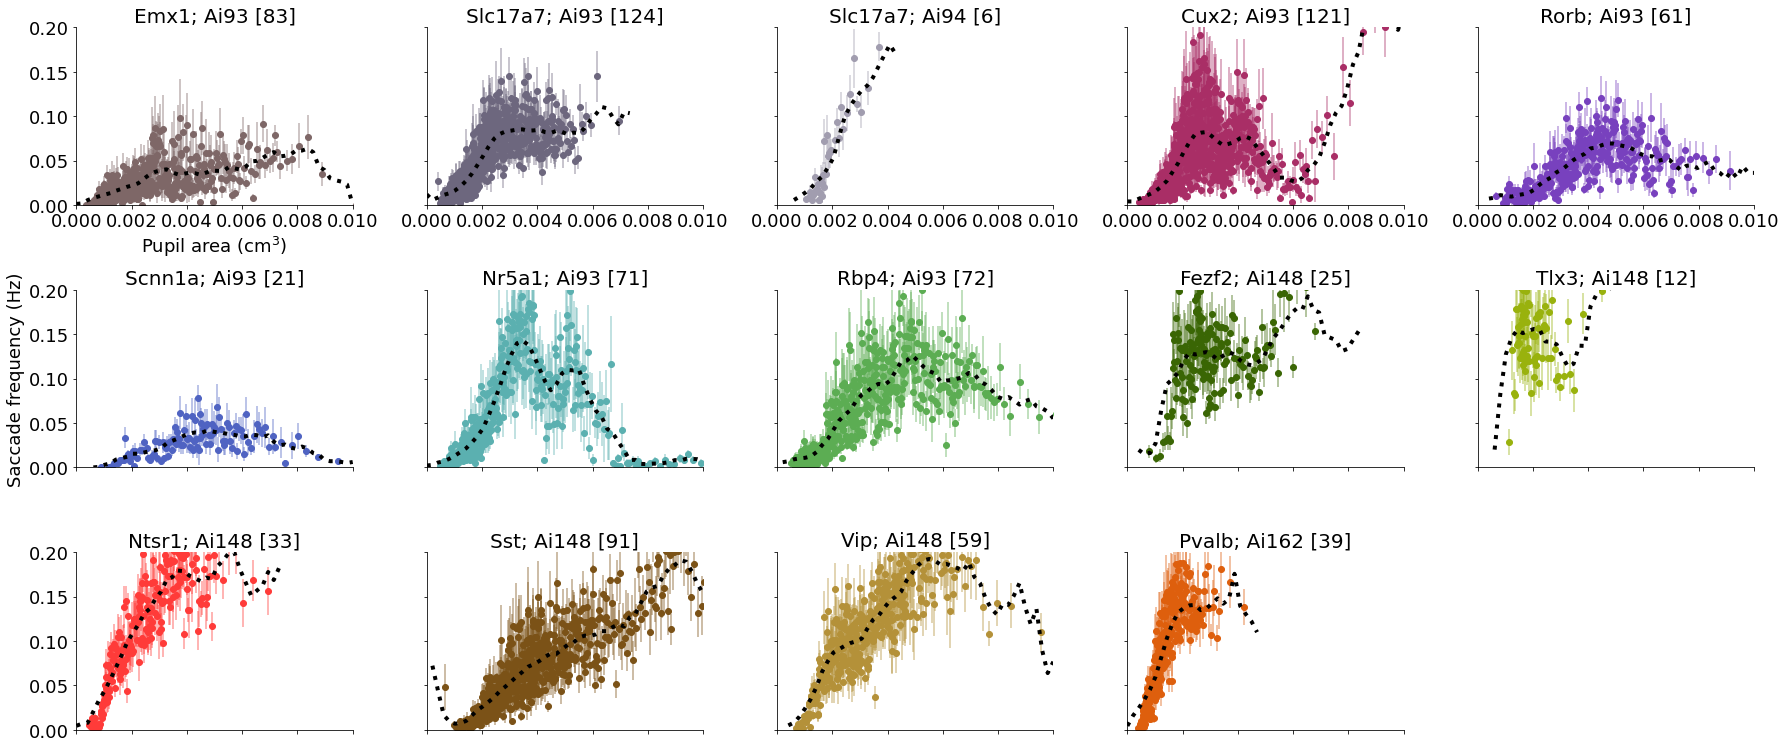

In [ ]:
n_rows = 3
n_cols = 5
fig = plt.figure(figsize=(n_cols*5, n_rows*3.5), facecolor="white")
bin_size = 10

for plt_i, cre in enumerate(CRE_ORDERING):
    mask = df_binned["cre_abbrev"] == cre
    x_vals = df_binned["mean_pupil_area"].values[mask]
    y_vals = df_binned["mean_sacc_per_sec"].values[mask]
    sort_idx = np.argsort(x_vals)
    x_vals[:] = x_vals[sort_idx]
    y_vals[:] = y_vals[sort_idx]

    x_plt = []
    y_plt = []
    y_err_plt = []

    for i in range(0, len(x_vals)-bin_size+1, bin_size):
        x = x_vals[i:i+bin_size].mean()
        y = y_vals[i:i+bin_size].mean()
        y_err = np.std(y_vals[i:i+bin_size]) / np.sqrt(bin_size)

        x_plt.append(x)
        y_plt.append(y)
        y_err_plt.append(y_err)
    
    # # Rolling average
    avg_x = []
    avg_y = []

    for x in np.linspace(0, 0.01, 50):
        # radius = 5 if x > 10 else 2
        radius = 0.0005
        x_min, x_max = x-radius, x+radius
        mask = (x_min <= x_vals) & (x_vals <= x_max)
        n_points = mask.sum()

        if n_points >= 5:
            avg_x.append(x)
            avg_y.append(y_vals[mask].mean())
        elif n_points == 0 and (x_vals > x_max).sum() == 0:
            break

    ax = fig.add_subplot(n_rows, n_cols, plt_i+1)
    ax.scatter(x_plt, y_plt, color=CRE_COLORS[cre])
    ax.errorbar(x_plt, y_plt, yerr=y_err_plt, color=CRE_COLORS[cre], fmt="none", alpha=0.5)
    ax.plot(avg_x, avg_y, color="black", linestyle="dotted", linewidth=4, alpha=1)

    if plt_i == 0:
        ax.set_xlabel("Pupil area (cm$^3$)", fontsize=18)
    elif plt_i == n_cols:
        ax.set_ylabel("Saccade frequency (Hz)", fontsize=18)
    # else:
    
    if plt_i % n_cols != 0:
        # y tick labels on left side
        ax.set_yticklabels([])
    if plt_i >= n_cols:
        # x tick labels on the top
        ax.set_xticklabels([])
    n_mice = (df_experiments["cre_abbrev"] == cre).sum()
    ax.set_title(f"{cre} [{n_mice}]", fontsize=20)
    ax.set_xlim(0, 0.01)
    ax.set_ylim(0, 0.2)
    ax.tick_params(labelsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# fig.suptitle(f"Average running speed and saccade frequency (n = {sum(len(rows) for rows in cre_line_rows.values())}, n' = {len(df_rows_binned)}, bin size = {bin_size})", fontsize=20)
fig.tight_layout()
savefig(fig, "pupil_area_vs_sacc_freq_cre.png")